# Experiment 6
In this experiment, the adversarial learning technique is dropped altogether, a single Variational Graph-based auto-encoder is used, using the torch geometry implementation of the VGAE

VGAE proved to be inferior (to be tested) so back to experimenting with a model written from scratch

In [1]:
!ls ../../Projects/data/

 MNIST			       SWaT_Dataset_Normal_v1.xlsx
 SWaT_Dataset_Attack_v0.csv    WADI_14days_new.csv
 SWaT_Dataset_Attack_v0.xlsx  'WADI.A1_9 Oct 2017'
 SWaT_Dataset_Normal_v0.csv   'WADI.A2_19 Nov 2019'
 SWaT_Dataset_Normal_v0.xlsx   WADI_attackdataLABLE.csv
 SWaT_Dataset_Normal_v1.csv


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch_geometric.transforms as T

from torch.optim import Adam
from torch_geometric.utils import add_self_loops, remove_self_loops
from torch_geometric.nn import GAE, VGAE, GCNConv, GATConv
from torch_geometric.data import Data, Batch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from layers import *

from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score, recall_score

### Dataset:

In [2]:
df = pd.read_csv('../../Projects/data/SWaT_Dataset_Normal_v1.csv')
df = df.drop(columns=[' Timestamp', 'Normal/Attack'])
df = df.astype('float64')
mm = StandardScaler()
Normalized = pd.DataFrame(mm.fit_transform(df))
train_set = Normalized[: int(0.8 * Normalized.shape[0])]
validation_set = Normalized[int(0.8 * Normalized.shape[0]):]

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
window_size = 100
device

device(type='cuda')

### Dataloader:

In [4]:
window_size = 100

train_dataset = SWat_dataset(train_set, train_set, window_size, device)
validation_dataset = SWat_dataset(validation_set, validation_set, window_size, device)

batch_size = 4096
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

### Model:

In [5]:
class GEncoder(nn.Module):
    def __init__(self, num_nodes, window_size, alpha, k, device):
        super(GEncoder, self).__init__()
        self.num_nodes = num_nodes
        self.window_size = window_size
        self.conv1 = GCNLayer(window_size, 40)
        self.conv2 = GCNLayer(40, 17)
        self.idx = torch.arange(num_nodes).to(device)
        self.A = Graph_Directed_A(num_nodes, window_size, alpha, k, device)
        self.device = device

    def forward(self, X):
        X = torch.transpose(X, 1, 2)
        adj = self.A(self.idx)
        h = self.conv1(adj, X).relu()
        h = self.conv2(adj, h).relu()
        return h
        
        

class GCN_autoencoder(nn.Module):
    def __init__(self, encoder, num_nodes, window_size):
        super(GCN_autoencoder, self).__init__()
        self.window_size = window_size
        self.num_nodes = num_nodes
        self.encoder = encoder
        self.decoder = nn.Sequential(
            nn.Linear(867, 1650),
            nn.ReLU(),
            nn.Linear(1650, num_nodes * window_size)
        )
        
    def forward(self, X):
        x = self.encoder(X)
        x = torch.flatten(x,1)
        x = self.decoder(x)
        return x.view(-1, self.window_size, self.num_nodes)

    def get_adj(self):
        return self.encoder.A(self.encoder.idx)

In [6]:
num_nodes = 51 # number of nodes
alpha = 0.15 # hyperparameter for weights of edges
k = None  # max number of edges for each node
epochs = 50
hidden_size = 23
dropout = 0.3
heads = 3

In [7]:
Encoder = GEncoder(num_nodes, window_size, alpha, k, device)
AE1 = GCN_autoencoder(Encoder, num_nodes, window_size)

In [8]:
AE1.to(device)

GCN_autoencoder(
  (encoder): GEncoder(
    (conv1): GCNLayer(
      (dense): Linear(in_features=100, out_features=40, bias=True)
    )
    (conv2): GCNLayer(
      (dense): Linear(in_features=40, out_features=17, bias=True)
    )
    (A): Graph_Directed_A(
      (e1): Embedding(51, 100)
      (e2): Embedding(51, 100)
      (l1): Linear(in_features=100, out_features=100, bias=True)
      (l2): Linear(in_features=100, out_features=100, bias=True)
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=867, out_features=1650, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1650, out_features=5100, bias=True)
  )
)

In [9]:
optimizer1 = torch.optim.Adam(AE1.parameters())
AE1.load_state_dict(torch.load('GAE_77_Directed_200_epochs.pth'))

RuntimeError: Error(s) in loading state_dict for GCN_autoencoder:
	Missing key(s) in state_dict: "decoder.2.weight", "decoder.2.bias". 
	Unexpected key(s) in state_dict: "decoder.3.weight", "decoder.3.bias". 
	size mismatch for encoder.conv1.dense.weight: copying a param with shape torch.Size([17, 10]) from checkpoint, the shape in current model is torch.Size([40, 100]).
	size mismatch for encoder.conv1.dense.bias: copying a param with shape torch.Size([17]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for encoder.conv2.dense.weight: copying a param with shape torch.Size([40, 17]) from checkpoint, the shape in current model is torch.Size([17, 40]).
	size mismatch for encoder.conv2.dense.bias: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([17]).
	size mismatch for encoder.A.e1.weight: copying a param with shape torch.Size([51, 10]) from checkpoint, the shape in current model is torch.Size([51, 100]).
	size mismatch for encoder.A.e2.weight: copying a param with shape torch.Size([51, 10]) from checkpoint, the shape in current model is torch.Size([51, 100]).
	size mismatch for encoder.A.l1.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([100, 100]).
	size mismatch for encoder.A.l1.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for encoder.A.l2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([100, 100]).
	size mismatch for encoder.A.l2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for decoder.0.weight: copying a param with shape torch.Size([1050, 2040]) from checkpoint, the shape in current model is torch.Size([1650, 867]).
	size mismatch for decoder.0.bias: copying a param with shape torch.Size([1050]) from checkpoint, the shape in current model is torch.Size([1650]).

In [9]:
# from torch.utils.tensorboard import SummaryWriter

In [10]:
AE1_val_history = []
for i in range(epochs):
    running_loss_AE1 = []
    val_loss_AE1 = []
    for index_b, features in enumerate(train_loader):
        
        w1 = AE1(features)
        lossAE1 = torch.mean((features - w1) ** 2)
        
        running_loss_AE1.append(lossAE1)
        lossAE1.backward()
        optimizer1.step()
        optimizer1.zero_grad()
    
    for index_b, features in enumerate(validation_loader):
        with torch.no_grad():

            w1 = AE1(features)
            lossAE1 = torch.mean((features - w1) ** 2)
            val_loss_AE1.append(lossAE1)
    AE1_val_history.append(torch.stack(val_loss_AE1).mean().item())
    # writer.add_scalar('Autoendoer_1_train_loss epoch', torch.stack(running_loss_AE1).mean().item(), i + 1)
    # writer.add_scalar('Autoendoer_1_train_loss epoch', AE1_val_history[-1], i + 1)
    print(f'Epoch: {i} ---> Val loss: AE1 {AE1_val_history[-1]:.4f}')
    print(f'Train loss: AE1 {torch.stack(running_loss_AE1).mean().item():.4f}')

NameError: name 'train_loader' is not defined

In [27]:
adj = AE1.get_adj()
adj2 = []
for orig_row in adj:
    row = [elem.item() if elem > 0.002 else 0 for elem in orig_row]
    adj2.append(row)
adj2 = torch.Tensor(adj2)
edge_index = get_edges(adj2)
edge_index, _ = remove_self_loops(edge_index)
edge_index, _ = add_self_loops(edge_index)
edge_index = edge_index.to(torch.int32).to(device)

In [28]:
train_dataset = SWat_dataset_GAT(train_set, train_set, window_size, edge_index, device)
validation_dataset = SWat_dataset_GAT(validation_set, validation_set, window_size, edge_index, device)

batch_size = 4096
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [29]:
def get_batch(tens, edges):
    list_data = []
    for row in tens:
        list_data.append(Data(x=row, edge_index=edges))
    return Batch.from_data_list(list_data)

In [30]:
class GAT(torch.nn.Module):
    def __init__(self, num_nodes, window_size, hidden_size, dropout, heads = 1):
        super(GAT, self).__init__()
        self.dropout = dropout
        
        self.conv1 = GATConv(window_size, hidden_size, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_size * heads, window_size, concat=False, dropout=dropout)

    def forward(self, batch):
        x, edge_index = batch.x, batch.edge_index
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        return self.conv2(x, edge_index)

In [31]:
GAT_AE = GAT(num_nodes, window_size, hidden_size, dropout, heads)
model = GAT_AE

In [32]:
GAT_AE.to(device)

GAT(
  (conv1): GATConv(100, 23, heads=3)
  (conv2): GATConv(69, 100, heads=1)
)

In [33]:
optimizer = torch.optim.Adam(model.parameters())

In [34]:
AE1_val_history = []
for i in range(epochs):
    running_loss_AE1 = []
    model.train()
    val_loss_AE1 = []
    for features in train_loader:
        batch = get_batch(features, edge_index)
        w1 = model(batch)
        lossAE1 = torch.mean((features - w1) ** 2)
        
        running_loss_AE1.append(lossAE1)
        lossAE1.backward()
        optimizer.step()
        optimizer.zero_grad()
    model.eval()
    for features in validation_loader:
        with torch.no_grad():
            batch = get_batch(features, edge_index)
            w1 = model(batch) 
            lossAE1 = torch.mean((features - w1) ** 2)
            val_loss_AE1.append(lossAE1)
    AE1_val_history.append(torch.stack(val_loss_AE1).mean().item())
    # writer.add_scalar('Autoendoer_1_train_loss epoch', torch.stack(running_loss_AE1).mean().item(), i + 1)
    # writer.add_scalar('Autoendoer_1_train_loss epoch', AE1_val_history[-1], i + 1)
    print(f'Epoch: {i} ---> Val loss: AE1 {AE1_val_history[-1]:.4f}')
    print(f'Train loss: AE1 {torch.stack(running_loss_AE1).mean().item():.4f}')

RuntimeError: The size of tensor a (51) must match the size of tensor b (208896) at non-singleton dimension 1

# Testing

In [12]:
df2 = pd.read_csv('../../Projects/data/SWaT_Dataset_Attack_v0.csv')
labels = df2['Normal/Attack']
df2 = df2.drop(columns=[' Timestamp', 'Normal/Attack'])
df2 = df2.astype('float64')
df2.columns = df.columns
test_normalized = pd.DataFrame(mm.transform(df2))

In [13]:
test_dataset = SWat_dataset(test_normalized, test_normalized, window_size, device)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [56]:
def testing(test_loader, alpha=.5, beta=.5):
    results=[]
    with torch.no_grad():
        for batch in test_loader:
            w1=AE1(batch)
            results.append(torch.mean(torch.mean((batch-w1)**2, axis=1), axis=1))
    return results

In [15]:
labels = labels.values
labels = [0 if (lab == 'Normal') else 1 for lab in labels]
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int32(labels[i:i+window_size])))

In [57]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels]

In [58]:
results=testing(test_loader, alpha=0.3, beta=0.7)

In [59]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

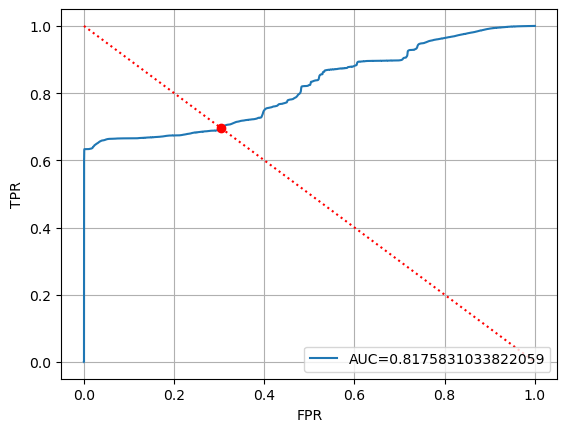

array([0.8405286], dtype=float32)

In [60]:
threshold = ROC(y_test,y_pred)
threshold

best: 1.6235294117647059 F1: 0.7726535599244697


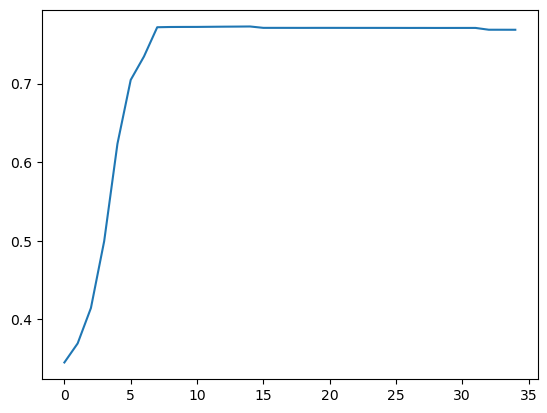

In [61]:
ff = 0
f_history = []
initial_y = 0.8
best = -1
for inc in np.linspace(0, 2, 35):
    y_pred_int = [1 if (yy > initial_y + inc) else 0 for yy in y_pred]
    conf_matrix = confusion_matrix(y_test, y_pred_int)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    F1 = f1_score(y_test, y_pred_int)
    f_history.append(F1)

    precision = precision_score(y_test, y_pred_int)
    recall = recall_score(y_test, y_pred_int)
    if F1 > ff:
        ff = F1
        best = inc
print(f'best: {best + initial_y} F1: {ff}')
plt.plot(f_history)

In [21]:
torch.save(AE1.state_dict(), 'GAE_77_Directed_200_epochs.pth')

In [ ]:
AE1.load_state_dict(torch.load('GAE_77_Directed_200_epochs.pth'))

In [21]:
def testing(loader, alpha=.5, beta=.5):
    results=[]
    with torch.no_grad():
        for batch in loader:
            w1=AE1(batch)
            results.append(torch.mean((batch-w1)**2, axis=1))
    return results

def get_threshold(val_loader):
    recon_errors = testing(val_loader)
    complete_vals = np.concatenate([torch.stack(recon_errors[:-1]).view(-1, num_nodes).detach().cpu().numpy(),
                                    recon_errors[-1].view(-1, num_nodes).detach().cpu().numpy()])
    return np.max(complete_vals, axis=0)

In [22]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels]

In [23]:
thresholds = get_threshold(validation_loader)
results=testing(test_loader, alpha=0.3, beta=0.7)
y_pred=np.concatenate([torch.stack(results[:-1]).view(-1, num_nodes).detach().cpu().numpy(), 
                       results[-1].view(-1, num_nodes).detach().cpu().numpy()])

In [24]:
factor = 1

In [43]:
factor = 720
res = y_pred > (thresholds * factor)
boo = np.any(res, axis = 1)
verdicts = [1 if elem else 0 for elem in boo]
conf_matrix = confusion_matrix(y_test, verdicts)
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
F1 = f1_score(y_test, verdicts)
precision = precision_score(y_test, verdicts)
recall = recall_score(y_test, verdicts)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", F1)
print(f'TP: {TP}\nTN: {TN}\nFP: {FP}\nFN: {FN}')
print(f'Factor is: {factor}')

Precision: 0.9892194788940721
Recall: 0.6330457259356342
F1 Score: 0.7720330328997026
TP: 34777
TN: 394594
FP: 379
FN: 20159
Factor is: 720
